## LAB 2.1 B: Multiclass Classification with Pytorch

### Proceedure:

- Build model, test on Natural Scenes
- Build model, test on Dogs-Cats-Pandas

In [1]:
import torch

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU device name:", torch.cuda.get_device_name(0))
    print("CUDA version:", torch.version.cuda)

PyTorch version: 2.5.1
CUDA available: True
GPU device name: NVIDIA GeForce RTX 3060
CUDA version: 12.1


In [2]:
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

DATA_PATH = "data/intel_image_data/"

data_dir = DATA_PATH + "seg_train/"
test_data_dir = DATA_PATH + "seg_test/"

dataset = ImageFolder(data_dir,transform = transforms.Compose([
transforms.Resize((150,150)),transforms.ToTensor()
]))
test_dataset = ImageFolder(test_data_dir,transforms.Compose([
transforms.Resize((150,150)),transforms.ToTensor()
]))

img, label = dataset[0]
print(img.shape,label)
print(dataset.classes)

torch.Size([3, 150, 150]) 0
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


Label : buildings


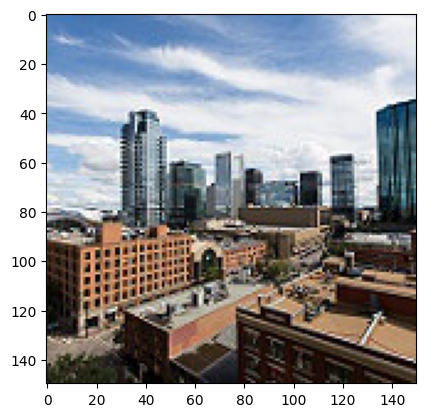

In [3]:
def get_default_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

def display_img(img,label):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))
    plt.show()

def show_batch(dl):
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        plt.show()
        break

display_img(*dataset[1])

In [4]:
batch_size = 128
val_size = 2000
train_size = len(dataset) - val_size
train_data,val_data = random_split(dataset,[train_size,val_size])

train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_data, batch_size*2, num_workers = 4, pin_memory = True)
test_dl = DataLoader(test_dataset, batch_size*2, num_workers = 4, pin_memory = True)
device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

### Note:

I reduced parameters of the CNN due to hardware limitation

In [10]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

class NaturalSceneClassification(ImageClassificationBase):
    def __init__(self, num_classes=6):
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            
            nn.Linear(20736, 256),
            nn.ReLU(),
            
            nn.Linear(256, num_classes)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [11]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

model = to_device(NaturalSceneClassification(), device)
print(evaluate(model, val_dl))

num_epochs = 30
opt_func = torch.optim.Adam
lr = 0.001

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

{'val_loss': 1.7928969860076904, 'val_acc': 0.14682242274284363}
Epoch [0], train_loss: 1.1260, val_loss: 0.9180, val_acc: 0.6386
Epoch [1], train_loss: 0.8494, val_loss: 0.8127, val_acc: 0.6987
Epoch [2], train_loss: 0.6959, val_loss: 0.7019, val_acc: 0.7332
Epoch [3], train_loss: 0.5852, val_loss: 0.6421, val_acc: 0.7603
Epoch [4], train_loss: 0.5078, val_loss: 1.1752, val_acc: 0.5947
Epoch [5], train_loss: 0.4949, val_loss: 0.7764, val_acc: 0.7322
Epoch [6], train_loss: 0.4468, val_loss: 0.6161, val_acc: 0.7828
Epoch [7], train_loss: 0.3305, val_loss: 0.5676, val_acc: 0.8123
Epoch [8], train_loss: 0.2586, val_loss: 0.7577, val_acc: 0.7559
Epoch [9], train_loss: 0.2560, val_loss: 0.6214, val_acc: 0.8096
Epoch [10], train_loss: 0.1423, val_loss: 0.7077, val_acc: 0.8049
Epoch [11], train_loss: 0.1239, val_loss: 0.7670, val_acc: 0.7939
Epoch [12], train_loss: 0.0763, val_loss: 0.8601, val_acc: 0.7886
Epoch [13], train_loss: 0.0624, val_loss: 0.8521, val_acc: 0.8040
Epoch [14], train_los

## Accuracy on Natural Scenes

In [15]:
final_result = evaluate(model, test_dl)
print(f"Accuracy: {final_result['val_acc']:.4f}")

Accuracy: 0.7629


In [16]:
DCP_DATA_PATH = "data/dogs_cats_pandas/"
dcp_full_data_dir = DCP_DATA_PATH + "animals/"

dcp_full_dataset = ImageFolder(dcp_full_data_dir,transform = transforms.Compose([
transforms.Resize((150,150)),transforms.ToTensor()
]))

dcp_total_size = len(dcp_full_dataset)
dcp_train_size = int(0.8 * dcp_total_size)
dcp_test_size = dcp_total_size - dcp_train_size

dcp_train_data, dcp_test_data = random_split(dcp_full_dataset, [dcp_train_size, dcp_test_size])

dcp_num_classes = len(dcp_full_dataset.classes)

print(f"Total DCP Samples: {dcp_total_size}")
print(f"DCP Train Samples (80%): {len(dcp_train_data)}")
print(f"DCP Test Samples (20%): {len(dcp_test_data)}")
print(f"DCP Classes: {dcp_full_dataset.classes}")

Total DCP Samples: 3000
DCP Train Samples (80%): 2400
DCP Test Samples (20%): 600
DCP Classes: ['cats', 'dogs', 'panda']


## Testing on Dogs-Cats-Pandas dataset

In [18]:
DCP_BATCH_SIZE = 64 

dcp_train_dl = DataLoader(dcp_train_data, DCP_BATCH_SIZE, shuffle = True, num_workers = 4, pin_memory = True)
dcp_test_dl = DataLoader(dcp_test_data, DCP_BATCH_SIZE * 2, num_workers = 4, pin_memory = True)

dcp_train_dl = DeviceDataLoader(dcp_train_dl, device)
dcp_test_dl = DeviceDataLoader(dcp_test_dl, device)

print(f"Using device: {device}")

dcp_model = to_device(NaturalSceneClassification(num_classes=dcp_num_classes), device)
print("Initial Evaluation on Test set (DCP):")
print(evaluate(dcp_model, dcp_test_dl))

DCP_NUM_EPOCHS = 20
DCP_LR = 0.001

print("\n--- STARTING DCP MODEL TRAINING ---")
dcp_history = fit(DCP_NUM_EPOCHS, DCP_LR, dcp_model, dcp_train_dl, dcp_test_dl, opt_func=torch.optim.Adam)

dcp_final_result = evaluate(dcp_model, dcp_test_dl)
print("\n--- FINAL RESULTS ON TEST SET (DCP) ---")
print(f"Accuracy: {dcp_final_result['val_acc']:.4f}")
print(f"Loss: {dcp_final_result['val_loss']:.4f}")

Using device: cuda
Initial Evaluation on Test set (DCP):
{'val_loss': 1.1025199890136719, 'val_acc': 0.30213066935539246}

--- STARTING DCP MODEL TRAINING ---
Epoch [0], train_loss: 0.8893, val_loss: 0.7499, val_acc: 0.5801
Epoch [1], train_loss: 0.6939, val_loss: 0.6717, val_acc: 0.7075
Epoch [2], train_loss: 0.6130, val_loss: 0.6982, val_acc: 0.6814
Epoch [3], train_loss: 0.5358, val_loss: 0.6628, val_acc: 0.6797
Epoch [4], train_loss: 0.4553, val_loss: 0.6278, val_acc: 0.7401
Epoch [5], train_loss: 0.3792, val_loss: 0.6451, val_acc: 0.7432
Epoch [6], train_loss: 0.3173, val_loss: 0.6778, val_acc: 0.7338
Epoch [7], train_loss: 0.2520, val_loss: 0.8802, val_acc: 0.7006
Epoch [8], train_loss: 0.1959, val_loss: 0.9195, val_acc: 0.7078
Epoch [9], train_loss: 0.1277, val_loss: 0.9324, val_acc: 0.7234
Epoch [10], train_loss: 0.0729, val_loss: 1.1590, val_acc: 0.7273
Epoch [11], train_loss: 0.0597, val_loss: 1.2262, val_acc: 0.7143
Epoch [12], train_loss: 0.0341, val_loss: 1.4671, val_acc: 